# Electricity Load Forecasting with Random Forest (Extended Feature Set)

This notebook retrains and evaluates the multi-horizon Random Forest model using an extended set of lagged features.  
The modeling pipeline, evaluation strategy, and train–test split remain identical to the baseline configuration to ensure full comparability.  
Any differences in forecasting performance can therefore be attributed solely to the expanded feature set.  
Model performance is assessed using standard error metrics, complemented by feature importance and SHAP analyses for interpretability.


## Imports

In [19]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import shap
import joblib
import seaborn as sns
from mrmr import mrmr_regression

## Loading the Data

In [3]:
# Define the paths for loading the tuned data
interim_folder = "../data/processed"

# Load the extended train/validation and test datasets
train_val_df = pd.read_csv(
    os.path.join(interim_folder, "train_val_df_extended.csv"),
    sep=";",
    decimal=","
)

test_df = pd.read_csv(
    os.path.join(interim_folder, "test_df_extended.csv"),
    sep=";",
    decimal=","
)

In [4]:
train_val_df.head(1)

,timestamp,load_MWh,lag_1,lag_2,lag_3,lag_4,lag_6,lag_7,lag_8,lag_9,...,lag_96,lag_120,lag_144,lag_168,lag_336,lag_672,lag_8760,hour,weekday,is_weekend
0,2022-01-01 01:00:00,41535.75,43915.5,45616.75,47461.5,48751.75,55785.75,58528.5,58442.5,55700.75,...,45682.0,44758.0,44051.5,41509.0,49242.25,54252.25,44569.25,1,5,1


In [5]:
test_df.head(1)

,timestamp,load_MWh,lag_1,lag_2,lag_3,lag_4,lag_6,lag_7,lag_8,lag_9,...,lag_96,lag_120,lag_144,lag_168,lag_336,lag_672,lag_8760,hour,weekday,is_weekend
0,2024-01-01 00:00:00,40170.25,42140.0,44088.5,45158.75,47080.5,52607.25,52685.5,50203.0,48502.25,...,42851.0,40705.25,39132.5,40748.0,47626.0,49797.5,40646.5,0,0,0


## Data Preparation

In [6]:
# Convert timestamp to datetime
train_val_df["timestamp"] = pd.to_datetime(train_val_df["timestamp"])
test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])

In [7]:
# Define the features and targets
feature_cols = [c for c in train_val_df.columns if c not in ["timestamp", "load_MWh"]]
target_col = "load_MWh"

X_trainval = train_val_df[feature_cols]
y_trainval = train_val_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]

print(f"Train/Val samples: {X_trainval.shape[0]}, Test samples: {X_test.shape[0]}")
print(f"Feature count: {len(feature_cols)}")

Train/Val samples: 17517, Test samples: 8783
Feature count: 35


## Building the Random Forest Models

### 1. Loading the Best Parameters of the Grid Search
To ensure comparability, the hyperparameters obtained from the grid search of the baseline Random Forest model are reused without modification.  
This allows the effect of the extended feature set to be evaluated independently of further hyperparameter tuning.

In [8]:
grid_results_dir = "../models/RF/grid_search_results"

best_params_24h = joblib.load(
    os.path.join(grid_results_dir, "best_params_24h.joblib")
)

best_rmse_24h = joblib.load(
    os.path.join(grid_results_dir, "best_rmse_24h.joblib")
)

In [9]:
summary_df = pd.read_csv(
    os.path.join(grid_results_dir, "grid_search_summary.csv")
)
summary_df.head()

,horizon,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,cv_rmse
0,1,20.0,sqrt,1,2,400,1802.267792
1,2,NaN,sqrt,1,2,400,2230.174003
2,3,20.0,sqrt,1,2,200,2495.690638
3,4,NaN,sqrt,1,2,200,2597.926023
4,5,20.0,sqrt,1,2,400,2683.450922


### 2. Final Model Training
In this step, a separate Random Forest model is trained for each forecast horizon (1–24 hours ahead) using the previously optimized hyperparameters.
By training 24 individual models, each one specializes in predicting a specific time step into the future, rather than relying on a single generic model.
This approach improves forecast accuracy and stability, as each model can adapt to the distinct temporal dynamics and feature relationships relevant to its prediction horizon.

In [10]:
# Train one Random Forest model for each forecast horizon (1–24 hours ahead)
models_24h = {}  # dictionary to store models for each hour
horizon = 24

for h in range(1, horizon + 1):
    print(f"Training model for hour {h} ahead...")

    # Shift the target by 'h' steps to create a horizon-specific target
    y_shifted = y_trainval.shift(-h)

    # Remove rows with NaN values caused by the shift
    valid_idx = y_shifted.notna()
    X_train_h = X_trainval.loc[valid_idx]
    y_train_h = y_shifted.loc[valid_idx]

    # Train the model using the best hyperparameters for this horizon
    model = RandomForestRegressor(random_state=42, **best_params_24h[h])
    model.fit(X_train_h, y_train_h)

    # Save the trained model for this forecast horizon
    models_24h[h] = model

print("Trained and stored 24 separate Random Forest models (1–24 hours ahead).")


Training model for hour 1 ahead...
Training model for hour 2 ahead...
Training model for hour 3 ahead...
Training model for hour 4 ahead...
Training model for hour 5 ahead...
Training model for hour 6 ahead...
Training model for hour 7 ahead...
Training model for hour 8 ahead...
Training model for hour 9 ahead...
Training model for hour 10 ahead...
Training model for hour 11 ahead...
Training model for hour 12 ahead...
Training model for hour 13 ahead...
Training model for hour 14 ahead...
Training model for hour 15 ahead...
Training model for hour 16 ahead...
Training model for hour 17 ahead...
Training model for hour 18 ahead...
Training model for hour 19 ahead...
Training model for hour 20 ahead...
Training model for hour 21 ahead...
Training model for hour 22 ahead...
Training model for hour 23 ahead...
Training model for hour 24 ahead...
Trained and stored 24 separate Random Forest models (1–24 hours ahead).


In [11]:
# Save the trained models
# Define model save path
model_dir = "../models/RF_tuned"
os.makedirs(model_dir, exist_ok=True)

# Save each trained model
for h, model in models_24h.items():
    model_path = os.path.join(model_dir, f"rf_model_h{h}.joblib")
    joblib.dump(model, model_path)
    print(f"Saved model for hour {h} → {model_path}")

print(f"All 24 Random Forest models successfully saved to: {model_dir}")

Saved model for hour 1 → ../models/RF_tuned/rf_model_h1.joblib
Saved model for hour 2 → ../models/RF_tuned/rf_model_h2.joblib
Saved model for hour 3 → ../models/RF_tuned/rf_model_h3.joblib
Saved model for hour 4 → ../models/RF_tuned/rf_model_h4.joblib
Saved model for hour 5 → ../models/RF_tuned/rf_model_h5.joblib
Saved model for hour 6 → ../models/RF_tuned/rf_model_h6.joblib
Saved model for hour 7 → ../models/RF_tuned/rf_model_h7.joblib
Saved model for hour 8 → ../models/RF_tuned/rf_model_h8.joblib
Saved model for hour 9 → ../models/RF_tuned/rf_model_h9.joblib
Saved model for hour 10 → ../models/RF_tuned/rf_model_h10.joblib
Saved model for hour 11 → ../models/RF_tuned/rf_model_h11.joblib
Saved model for hour 12 → ../models/RF_tuned/rf_model_h12.joblib
Saved model for hour 13 → ../models/RF_tuned/rf_model_h13.joblib
Saved model for hour 14 → ../models/RF_tuned/rf_model_h14.joblib
Saved model for hour 15 → ../models/RF_tuned/rf_model_h15.joblib
Saved model for hour 16 → ../models/RF_tune

### 3. Testing on Future Data
This step evaluates the 24 trained Random Forest models on the unseen test dataset.
Each model is responsible for predicting a specific forecast horizon (1–24 hours ahead), enabling a full-day load forecast.
By applying the models to new, unseen data, the function measures how well the models generalize beyond the training period.
Performance is assessed using RMSE and MAPE per forecast step and overall, while forecast errors are recorded per horizon for detailed error distribution analysis.

In [12]:
def multi_model_24h_forecast(models_24h, X_test, y_test, horizon=24, step=24, eps=1e-6):
    """
    Direct multi-horizon forecasting with 24 separate models (1..24 hours ahead).

    Definition:
      - Forecast origin is time t (row index = start)
      - Model h predicts target at t+h
      - Therefore, the truth block is y[t+1] .. y[t+24]

    Evaluation can be done with:
      - step=24 (non-overlapping daily origins) or
      - step=1  (hourly origins, overlapping)

    Returns:
      - all_preds, all_truth (flattened, length = n_windows * horizon)
      - rmse_per_horizon (length = horizon)
      - mape_per_horizon (length = horizon)
      - errors_by_horizon (dict: h -> list of errors)
    """
    all_preds = []
    all_truth = []
    errors_by_horizon = {h: [] for h in range(1, horizon + 1)}

    sse_per_h = np.zeros(horizon)  # sum of squared errors per horizon
    ape_per_h = np.zeros(horizon)  # sum of abs percentage errors per horizon
    n_windows = 0

    y_test_values = np.asarray(y_test)

    # need y_block = y[start+1 : start+1+horizon], so start must allow start+1+horizon <= len(y)
    for start in range(0, len(X_test) - (horizon + 1) + 1, step):
        X_origin = X_test.iloc[[start]]  # features at time t
        y_block = y_test_values[start + 1 : start + 1 + horizon]  # truth: t+1 .. t+24

        preds_24h = np.zeros(horizon)

        for h in range(1, horizon + 1):
            model = models_24h[h]
            yhat = model.predict(X_origin)[0]
            preds_24h[h - 1] = yhat

            err = y_block[h - 1] - yhat
            errors_by_horizon[h].append(err)

        errs = y_block - preds_24h
        sse_per_h += errs ** 2
        ape_per_h += np.abs(errs) / np.clip(np.abs(y_block), eps, None) * 100

        all_preds.extend(preds_24h.tolist())
        all_truth.extend(y_block.tolist())
        n_windows += 1

    rmse_per_horizon = np.sqrt(sse_per_h / n_windows)
    mape_per_horizon = ape_per_h / n_windows

    total_rmse = np.sqrt(mean_squared_error(all_truth, all_preds))
    total_mape = np.mean(
        np.abs((np.array(all_truth) - np.array(all_preds)) / np.clip(np.abs(np.array(all_truth)), eps, None))
    ) * 100

    print(f"Overall RMSE: {total_rmse:.2f}")
    print(f"Overall MAPE: {total_mape:.2f}%")

    return (
        np.array(all_preds),
        np.array(all_truth),
        rmse_per_horizon,
        mape_per_horizon,
        errors_by_horizon
    )


horizon = 24
step = 24

preds, truth, mean_rmse_h, mean_mape_h, errors_by_horizon = multi_model_24h_forecast(
    models_24h=models_24h,
    X_test=X_test,
    y_test=y_test,
    horizon=horizon,
    step=step
)

# create matching timestamps for truth/preds (t+1 .. t+24 for each origin t)
origin_idx = list(range(0, len(test_df) - (horizon + 1) + 1, step))

timestamps = []
for start in origin_idx:
    timestamps.extend(test_df["timestamp"].iloc[start + 1 : start + 1 + horizon].tolist())

results_df = pd.DataFrame({
    "timestamp": timestamps,
    "Actual_Load_MWh": truth,
    "Predicted_Load_MWh": preds
})

Overall RMSE: 2371.34
Overall MAPE: 2.99%


## Visualization of the Model Performance
### 1. Daily Average Electricity Load: Actual vs Predicted
This section compares the predicted and actual electricity load on the test dataset.
Hourly predictions are aggregated to daily averages to visualize overall forecast accuracy and capture long-term trends.
The plot illustrates how closely the Random Forest models reproduce real load patterns throughout the test year, providing an intuitive check of model performance and temporal consistency.

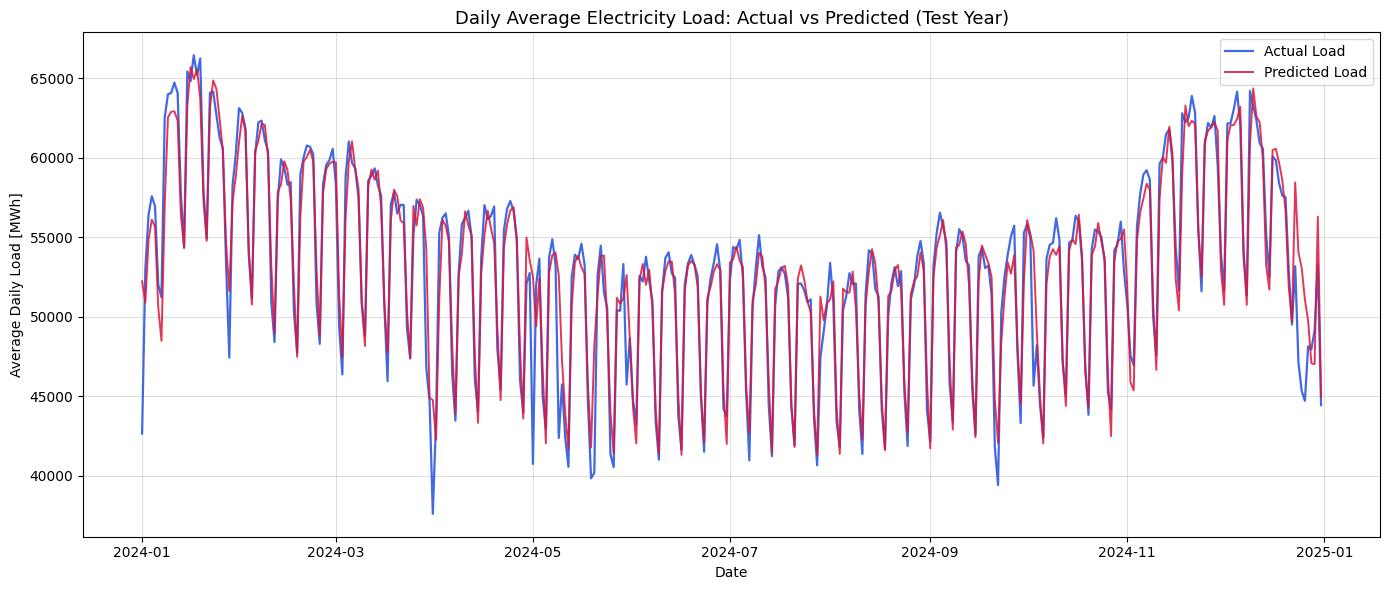

In [13]:
# Convert timestamp and aggregate daily means
results_df["timestamp"] = pd.to_datetime(results_df["timestamp"])
daily_df = results_df.resample("D", on="timestamp").mean()

# Plot daily aggregated actual vs predicted load
plt.figure(figsize=(14,6))
plt.plot(daily_df.index, daily_df["Actual_Load_MWh"], label="Actual Load", color="royalblue", linewidth=1.6)
plt.plot(daily_df.index, daily_df["Predicted_Load_MWh"], label="Predicted Load", color="crimson", linewidth=1.4, alpha=0.85)
plt.title("Daily Average Electricity Load: Actual vs Predicted (Test Year)", fontsize=13)
plt.xlabel("Date")
plt.ylabel("Average Daily Load [MWh]")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()


**Key Findings – Actual vs. Predicted Daily Load (Extended Feature Set)**

- The predicted daily load closely tracks the actual load throughout the test year, indicating that the Random Forest model maintains **strong generalization performance** when trained on the extended feature set.  
- Seasonal patterns, including **high winter demand and lower summer consumption**, are reproduced accurately, while daily fluctuations remain well aligned with observations.  
- Compared to the baseline configuration, deviations during periods of pronounced load changes are slightly reduced, suggesting an improved representation of **intraday and short-term dynamics**.  
- Overall, the results show that the extended feature set enhances the model’s ability to capture **temporal structure and recurring patterns**, while preserving stable and reliable forecasting performance over the entire test period.

### 2. Average RMSE & MAPE per Forecast Step
This section visualizes the average RMSE and MAPE for all 24 forecast horizons to assess how prediction accuracy changes with the forecast step.
The plots reveal how errors evolve as the model predicts further into the future, providing insight into short-term vs. long-term forecast reliability.
Together, they highlight the model’s ability to maintain stable performance while quantifying the gradual increase in uncertainty typical of multi-step forecasting.

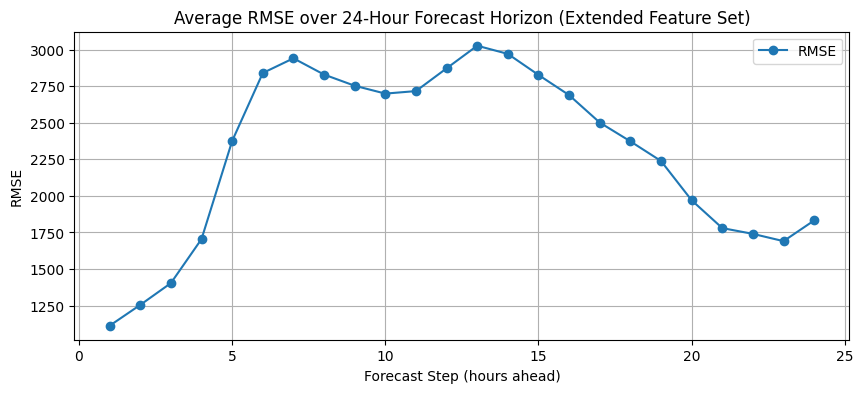

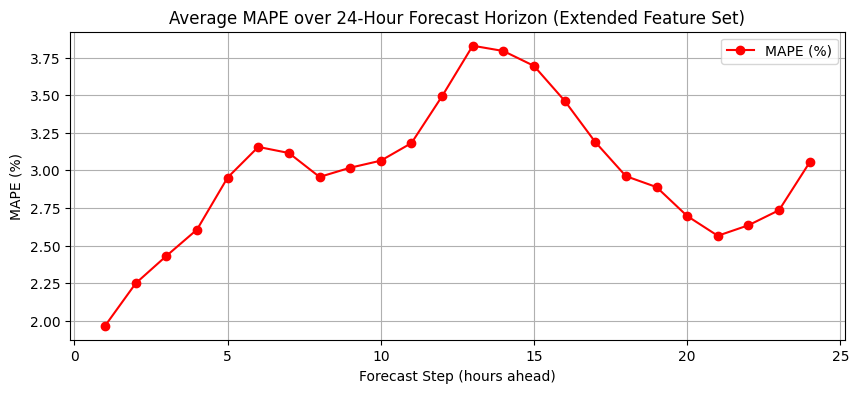

In [14]:
# Plot Average RMSE over 24 forecast steps (extended feature set)
plt.figure(figsize=(10,4))
plt.plot(range(1, 25), mean_rmse_h, marker='o', label='RMSE')
plt.title("Average RMSE over 24-Hour Forecast Horizon (Extended Feature Set)")
plt.xlabel("Forecast Step (hours ahead)")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.show()

# Plot Average MAPE over 24 forecast steps (extended feature set)
plt.figure(figsize=(10,4))
plt.plot(range(1, 25), mean_mape_h, color='red', marker='o', label='MAPE (%)')
plt.title("Average MAPE over 24-Hour Forecast Horizon (Extended Feature Set)")
plt.xlabel("Forecast Step (hours ahead)")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.legend()
plt.show()

**Key Findings – Forecast Accuracy Across Horizons (Extended Feature Set)**

- Both **RMSE** and **MAPE** exhibit a clear horizon-dependent pattern, reflecting increasing uncertainty as the forecast extends further into the future.  
- The **lowest errors** are observed in the **very short-term (1–3 hours ahead)**, where recent load information is most informative.  
- A pronounced increase in error occurs between **4 and 6 hours ahead**, indicating a transition from short-term to more uncertain intraday forecasts.  
- Error levels peak around **12–15 hours ahead**, corresponding to periods of changing daily load dynamics and intraday regime shifts.  
- Toward longer horizons, errors **decline again approaching 24 hours ahead**, suggesting that the model benefits from the strong **daily periodicity** captured by the extended lag structure.  
- Overall, the tuned Random Forest model demonstrates **robust and stable performance** across the full 24-hour forecast horizon, with particularly strong accuracy in both short-term and end-of-day predictions.

### 3. Error Distribution Comparison
This section visualizes the distribution of prediction errors for each forecast horizon (1–24 hours ahead) using boxplots.
The plot highlights how the error spread and bias change with the prediction step, revealing where the model tends to overestimate or underestimate the load.
It provides a deeper understanding of forecast stability and uncertainty across different time horizons.

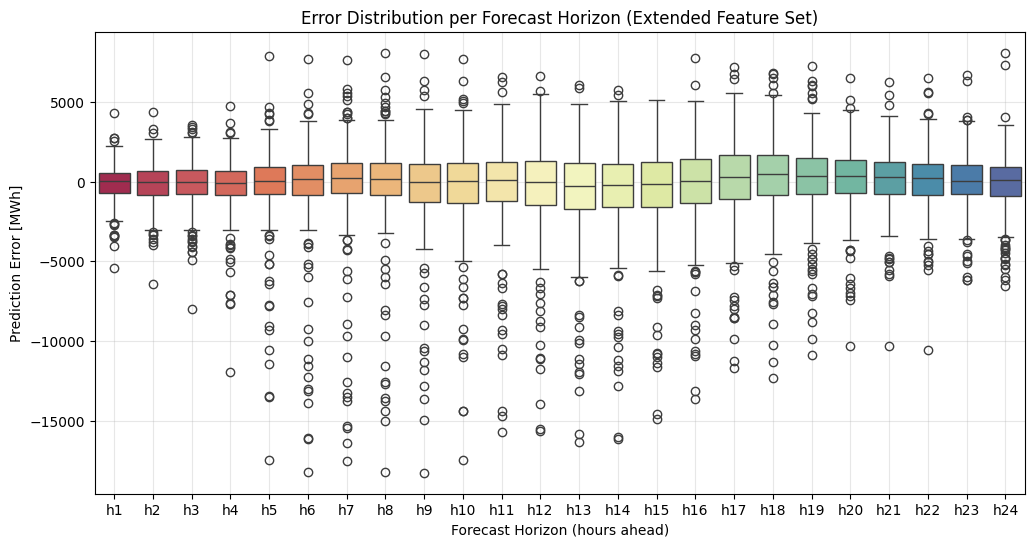

In [15]:
errors_df = pd.DataFrame({f"h{h}": errors_by_horizon[h] for h in range(1, 25)})

plt.figure(figsize=(12,6))
sns.boxplot(data=errors_df, palette="Spectral")
plt.title("Error Distribution per Forecast Horizon (Extended Feature Set)")
plt.xlabel("Forecast Horizon (hours ahead)")
plt.ylabel("Prediction Error [MWh]")
plt.grid(True, alpha=0.3)
plt.show()


**Key Findings – Error Distribution per Forecast Horizon (Extended Feature Set)**

- The **dispersion of forecast errors increases from short- to mid-range horizons**, indicating rising uncertainty as the prediction horizon extends.  
- **Short-term forecasts (1–4 hours ahead)** exhibit narrow, near-zero-centered error distributions, reflecting high accuracy and low systematic bias.  
- **Mid-range horizons (approximately 6–15 hours ahead)** show wider distributions and more pronounced outliers, pointing to increased volatility during intraday transitions.  
- A mild **negative bias** (tendency toward underestimation) is visible in the mid-range horizons, which gradually diminishes at longer forecast steps.  
- Toward the end of the 24-hour horizon, error distributions become more stable again, suggesting that the model benefits from **recurring daily patterns** captured by the extended lag structure.


## Explainable AI: Feature Importance and SHAP Analysis
### 1. Feature Importance Analysis
This section aggregates and visualizes the feature importances from all 24 Random Forest models.
By averaging the importance scores across all forecast horizons, it identifies which variables consistently contribute the most to accurate predictions.
The resulting bar chart highlights the most influential temporal and historical features, providing insight into the key drivers of electricity load forecasting.

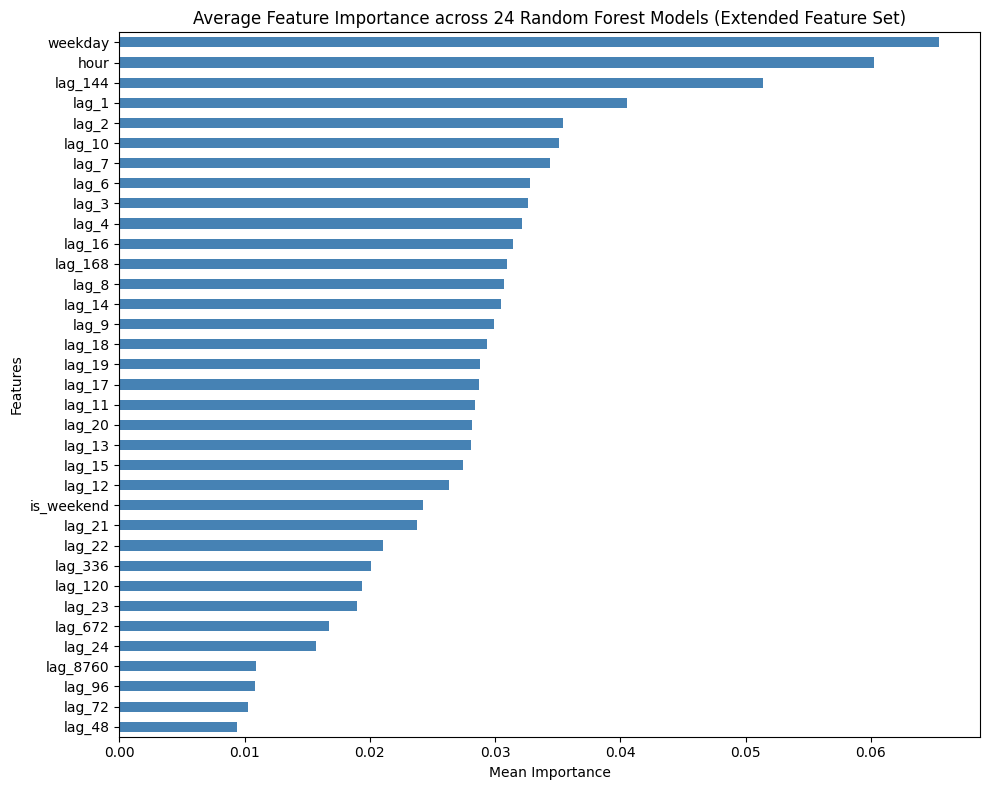

In [16]:
# Collect all feature importances from each model
importances_df = pd.DataFrame({
    h: models_24h[h].feature_importances_ for h in range(1, 25)
}, index=feature_cols)

# Compute mean importance across all forecast horizons
mean_importance = importances_df.mean(axis=1).sort_values(ascending=False)

# Plot feature importances (extended feature set)
plt.figure(figsize=(10,8))
mean_importance.plot(kind="barh", color="steelblue")
plt.gca().invert_yaxis()
plt.title("Average Feature Importance across 24 Random Forest Models (Extended Feature Set)")
plt.xlabel("Mean Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

**Key Findings – Feature Importance (Extended Feature Set)**

- The calendar features **`weekday`** and **`hour`** are the most influential variables by a clear margin, indicating that **weekly structure and intraday timing** are the dominant drivers of electricity demand in the Random Forest model.

- Among the lagged features, **`lag_144` (six days ahead)** stands out as the most important historical input, highlighting the relevance of **short-term recurring patterns across consecutive days**, beyond simple daily repetition.

- A wide range of **intraday lag features** (`lag_1` to `lag_20`) exhibit consistently high importance, suggesting that the model benefits from a **distributed representation of within-day dynamics** rather than relying on a single dominant short-term lag.

- The **weekly lag (`lag_168`)** remains relevant but is less influential than calendar features and short-term lags, indicating that weekly seasonality is largely captured through **explicit calendar information**.

- Longer-term lags such as **`lag_336`, `lag_672`, and `lag_8760`** contribute only marginally, confirming that **long-term seasonal effects play a secondary role** once detailed intraday and calendar-based features are available.

- Overall, the extended feature set shifts the model’s focus toward **fine-grained intraday structure and short-term cross-day dependencies**, while reducing reliance on long-range historical information.


### 2. Model Explainability with SHAP
This section applies SHAP (SHapley Additive exPlanations) to interpret the 1-hour-ahead Random Forest model.
By analyzing a representative test sample, SHAP quantifies each feature’s contribution to individual predictions.
The bar plot shows global feature importance based on average absolute SHAP values, while the beeswarm plot illustrates the direction and distribution of each feature’s effect on predicted load values.
Together, these plots enhance model transparency and confirm which features drive short-term electricity demand forecasts.

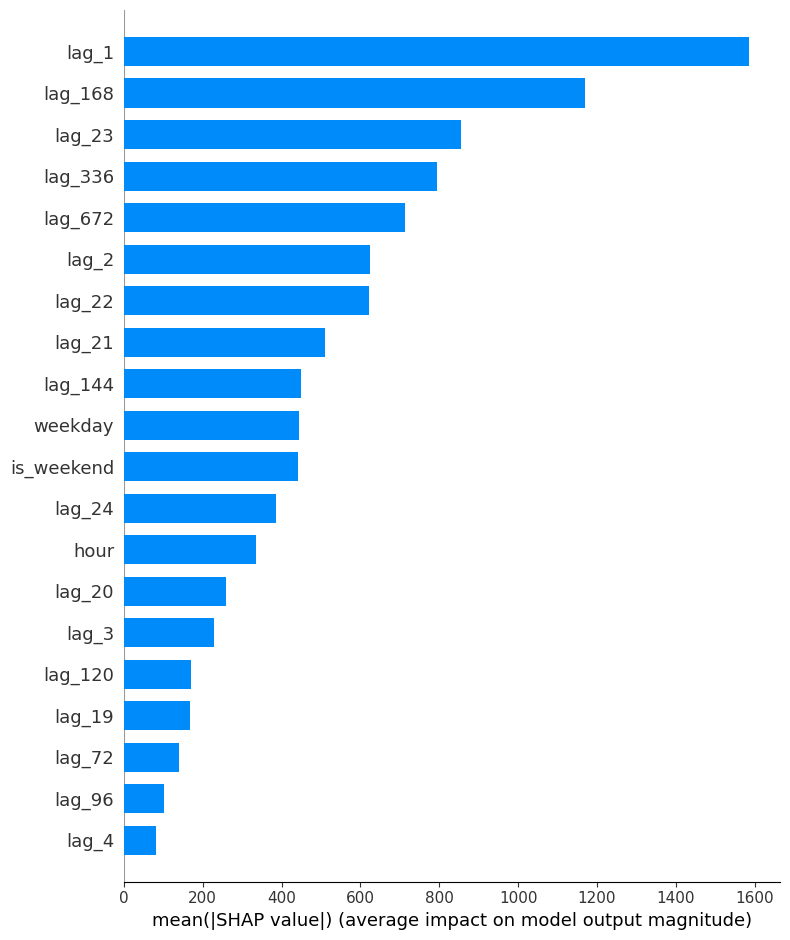

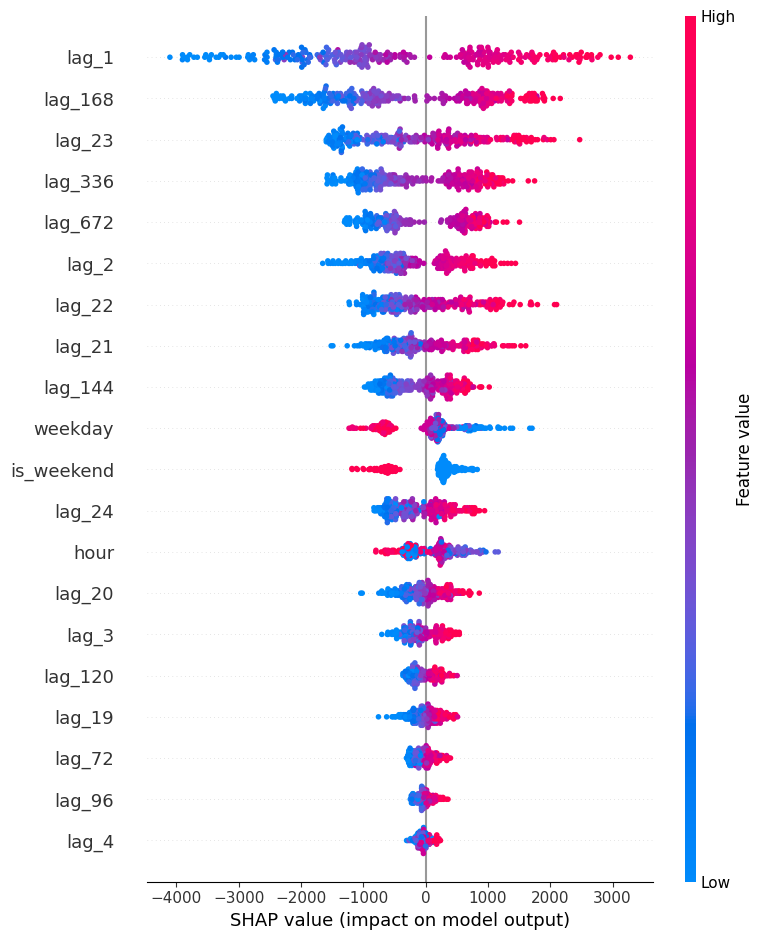

In [17]:
# Select one representative model, (the 1-hour ahead model)
model = models_24h[1]

# Use a smaller sample of test data for SHAP (to speed up computation)
X_sample = X_test.sample(300, random_state=42)

# Create SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

# Global Feature Importance (mean absolute SHAP values)
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=True)

# Detailed Distribution of Effects (beeswarm plot)
shap.summary_plot(shap_values, X_sample, show=True)


**Key Findings – SHAP Analysis (Extended Feature Set)**

- The SHAP analysis confirms that **recent load values** dominate the model’s decision-making process, with **`lag_1` (previous hour)** emerging as the single most influential predictor by a clear margin.  
  This highlights the strong dependence of short-term electricity demand on immediate past consumption.

- **`lag_168`** ranks second, indicating that **weekly seasonality** constitutes the most important recurring temporal structure beyond short-term dynamics.

- Several **intraday lag features** (e.g. `lag_23`, `lag_22`, `lag_21`, `lag_2`) appear among the top contributors, demonstrating that the extended feature set enables the model to capture **within-day load dynamics** in a detailed and distributed manner.

- **Multi-day lags** such as `lag_144`, `lag_336`, and `lag_672` contribute moderately, reflecting the influence of **short- to medium-term recurring patterns** across multiple days.

- Calendar features (**`weekday`, `is_weekend`, `hour`**) exhibit **consistent but clearly secondary effects** compared to lag-based features, providing contextual adjustments related to daily and weekly routines rather than acting as primary drivers.

- The beeswarm plot reveals largely **monotonic relationships** for lag-based features: higher past load values systematically increase predicted demand, while lower values decrease it.  
  This behavior confirms a **stable, intuitive, and interpretable decision structure** under the extended feature configuration.

### 4. Feature Selection with mRMR (Extended Feature Set)
To further assess whether the extended feature set introduces additional informative predictors,a model-agnostic feature selection using Minimum Redundancy Maximum Relevance (mRMR) is applied. This approach ranks features based on their relevance to the target variable while penalizing redundancy among predictors, providing an independent validation of the Random Forest feature importance results.

In [20]:
# Prepare data for mRMR (no timestamp, no NaNs)
X_mrmr = train_val_df.drop(columns=["timestamp", "load_MWh"])
y_mrmr = train_val_df["load_MWh"]

# Run mRMR regression (Top 20 features)
mrmr_features = mrmr_regression(
    X=X_mrmr,
    y=y_mrmr,
    K=20
)

mrmr_df = pd.DataFrame({
    "Rank": range(1, len(mrmr_features) + 1),
    "Feature": mrmr_features
})

mrmr_df

100%|██████████| 20/20 [00:00<00:00, 66.72it/s]


,Rank,Feature
0,1,lag_1
1,2,lag_168
2,3,lag_2
3,4,lag_336
4,5,lag_672
5,6,lag_24
6,7,lag_23
7,8,lag_3
8,9,lag_144
9,10,lag_22


In [21]:
# Compare mRMR ranking with RF feature importance
rf_top20 = mean_importance.head(20).reset_index()
rf_top20.columns = ["Feature", "RF_Importance"]

mrmr_comparison = mrmr_df.merge(rf_top20, on="Feature", how="left")
mrmr_comparison


,Rank,Feature,RF_Importance
0,1,lag_1,0.040557
1,2,lag_168,0.030974
2,3,lag_2,0.035414
3,4,lag_336,NaN
4,5,lag_672,NaN
5,6,lag_24,NaN
6,7,lag_23,NaN
7,8,lag_3,0.032643
8,9,lag_144,0.051409
9,10,lag_22,NaN


**Key Findings – mRMR Feature Ranking (Extended Feature Set)**

- The mRMR analysis confirms that **lag-based features** provide the highest informational value for short-term electricity load forecasting, with **very short-term lags** (`lag_1`, `lag_2`, `lag_3`) and **weekly seasonality (`lag_168`)** ranking at the top.

- **Intraday lag features** (`lag_22`, `lag_23`, `lag_24`) and **multi-day lags** (`lag_48`, `lag_72`, `lag_96`, `lag_120`, `lag_144`) contribute additional information but are clearly ranked below the dominant short-term and weekly dependencies.

- Longer-term seasonal lags (`lag_336`, `lag_672`, `lag_8760`) remain present in the ranking, indicating persistent seasonal structure, but their informational contribution is secondary compared to short-term dynamics.

- Calendar-based features such as **`is_weekend`** appear only in lower ranks, suggesting that their information content is largely **subsumed by lag-based features** capturing recurring consumption patterns.

- Importantly, the mRMR ranking does **not identify any newly introduced feature** from the extended feature set that provides substantially higher relevance than the core features already present in the baseline configuration.

- The strong agreement between **model-dependent Random Forest feature importance** and **model-independent mRMR rankings** indicates that the extended feature set mainly introduces **redundant information** rather than new explanatory power.

- This finding provides a plausible explanation for the **marginal performance improvements** observed for the Random Forest and the **lack of systematic gains** for the LSTM and transformer-based models when using the extended feature set.


## Overall Conclusion – Random Forest (Extended Feature Set)

Training the Random Forest model with the extended feature set leads to a **small but measurable improvement in predictive accuracy**, reducing the overall MAPE from 3.02% to 2.99%. This indicates that additional lagged features allow for a more fine-grained representation of intraday and short-term temporal dynamics. However, the magnitude of this improvement remains marginal.

Across the full 24-hour forecast horizon, the model continues to generalize robustly, exhibiting stable error behavior and consistent performance patterns. Explainability analyses based on feature importance and SHAP reveal that the **fundamental drivers of the forecasts remain unchanged**: short-term persistence and weekly seasonality continue to dominate the model’s decision-making process.

Both model-dependent explainability methods and the model-independent mRMR analysis consistently show that the extended feature set does **not introduce qualitatively new explanatory information**. Instead, importance is redistributed across multiple highly correlated lag features, indicating increased redundancy rather than additional insight into the underlying demand structure.

From an interpretability and knowledge-discovery perspective, the reduced feature set already captures the essential temporal dynamics of electricity demand. The extended feature set primarily refines the temporal resolution of these dynamics without yielding a substantial gain in explanatory power. Consequently, the extended configuration improves model flexibility but does not meaningfully deepen the understanding of the drivers of short-term electricity consumption.

